# AI Powered Task Management System - Feature Extraction Implementation

In [1]:
%pip install pandas numpy scikit-learn nltk gensim transformers torch
%pip install wordcloud matplotlib seaborn plotly
%pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# NLP and Word Embeddings
import nltk
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import torch
from sentence_transformers import SentenceTransformer

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Chandra
[nltk_data]     Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Chandra
[nltk_data]     Sena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('D:\AI TASK MANAGEMENT\Dataset\Task_management_Final.csv')
df.head()

,Issue Key,Summary,Description,Assignee,Reporter,Issue Type,Priority,Status,Component,Created,...,Due_Month,summary_cleaned,description_cleaned,combined_text,summary_lemmatized,description_lemmatized,combined_lemmatized,summary_word_count,description_word_count,combined_word_count
0,SWP-1,User Authentication Failure,Users unable to log in due to OAuth 2.0 token ...,Bob,Heidi,Bug,High,In Progress,Authentication,11-06-2025,...,6,user authentication failure,users unable to log in due to oauth token refr...,user authentication failure users unable to lo...,authentication failure,log oauth token refresh failure cause session ...,authentication failure log oauth token refresh...,3,14,17
1,SWP-2,Payment Gateway Transaction Error,Stripe payments intermittently fail with 500 e...,Eve,Grace,Bug,High,Open,Payment Processing,05-07-2025,...,7,payment gateway transaction error,stripe payments intermittently fail with error...,payment gateway transaction error stripe payme...,payment gateway transaction error,stripe payment intermittently fail error webho...,payment gateway transaction error stripe payme...,4,12,16
2,SWP-3,Database Migration Tool,Create automated database migration scripts to...,Bob,Judy,Task,High,Done,Database,02-06-2025,...,6,database migration tool,create automated database migration scripts to...,database migration tool create automated datab...,migration,automate migration script transition mysql pos...,migration automate migration script transition...,3,18,21
3,SWP-4,Push Notification Delivery Issue,Push notifications not delivered to iOS device...,Eve,Ivan,Bug,Medium,In Progress,Notifications,23-06-2025,...,7,push notification delivery issue,push notifications not delivered to ios device...,push notification delivery issue push notifica...,push delivery,push deliver device incorrect apns certificate,push delivery push deliver device incorrect ap...,4,13,17
4,SWP-5,API Rate Limiting Implementation,Build robust API rate limiting system with Red...,Frank,Ivan,Task,High,In Progress,API,04-06-2025,...,6,api rate limiting implementation,build robust api rate limiting system with red...,api rate limiting implementation build robust ...,rate limiting,robust rate limit redis backend dynamic thrott...,rate limiting robust rate limit redis backend ...,4,17,21


In [5]:
df.shape

(194, 24)

In [6]:
df.columns.tolist()

['Issue Key',
 'Summary',
 'Description',
 'Assignee',
 'Reporter',
 'Issue Type',
 'Priority',
 'Status',
 'Component',
 'Created',
 'Due Date',
 'Days to Complete',
 'Created_Month',
 'Created_Day_of_Week',
 'Due_Month',
 'summary_cleaned',
 'description_cleaned',
 'combined_text',
 'summary_lemmatized',
 'description_lemmatized',
 'combined_lemmatized',
 'summary_word_count',
 'description_word_count',
 'combined_word_count']

In [7]:
# Display basic statistics
print("\n=== DATA OVERVIEW ===")
print(f"Total records: {len(df)}")
print(f"Unique Issue Types: {df['Issue Type'].nunique()}")
print(f"Unique Priorities: {df['Priority'].nunique()}")
print(f"Unique Statuses: {df['Status'].nunique()}")


=== DATA OVERVIEW ===
Total records: 194
Unique Issue Types: 4
Unique Priorities: 3
Unique Statuses: 4


In [8]:
# Checking missing values in text columns
text_columns = ['summary_cleaned', 'description_cleaned', 'combined_text',
               'summary_lemmatized', 'description_lemmatized', 'combined_lemmatized']

In [9]:
print("=== MISSING VALUES IN TEXT COLUMNS ===")
for col in text_columns:
  if col in df.columns:
    non_empty = df[col].notna().sum()
    avg_length = df[col].dropna().str.len().mean()
    print(f"{col}:{non_empty} non empty entries, avg length:{avg_length:.1f}")

=== MISSING VALUES IN TEXT COLUMNS ===
summary_cleaned:194 non empty entries, avg length:24.9
description_cleaned:194 non empty entries, avg length:95.9
combined_text:194 non empty entries, avg length:121.9
summary_lemmatized:180 non empty entries, avg length:16.9
description_lemmatized:194 non empty entries, avg length:57.8
combined_lemmatized:194 non empty entries, avg length:74.5


In [10]:
# We will use combined_lemmatized as our main text feature
text_data = df['combined_lemmatized'].fillna('').astype(str)

print(f"\n Using 'combined_lemmatized' as main text feature")
print(f"Total text samples: {len(text_data)}")
print(f"Non empty text samples: {(text_data != '').sum()}")


 Using 'combined_lemmatized' as main text feature
Total text samples: 194
Non empty text samples: 194


In [13]:
print("\n=== SAMPLE TEXT DATA ===")
sample_indices = np.random.choice(len(df), 3, replace=False)
for i in sample_indices:
    print(f"\nSample {i+1}:")
    print(f"Text: {text_data.iloc[i]}")
    print(f"Issue Type: {df['Issue Type'].iloc[i]}")
    print(f"Priority: {df['Priority'].iloc[i]}")
    print(f"Status: {df['Status'].iloc[i]}")


=== SAMPLE TEXT DATA ===

Sample 131:
Text:  collection survey distribution sentiment analysis action track
Issue Type: Story
Priority: Medium
Status: In Progress

Sample 63:
Text: learn course access online training denies access enrol role misconfiguration
Issue Type: Bug
Priority: Medium
Status: Open

Sample 81:
Text: fraud detection realtime fraud monitoring machine learn model rule engine investigation
Issue Type: Task
Priority: High
Status: In Progress


# Feature Extraction Using TF-IDF

In [14]:
class TFIDFExtractor:
  def __init__(self, max_features=5000, ngram_range=(1,2)):
    self.vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,                                # Ignore terms in less than 2 documents
        max_df=0.8,                              # Ignore terms in more than 80% of documents
        ngram_range=ngram_range,                 # Use unigrams and bigrams
        stop_words='english',                     # Remove English stop words
        lowercase = True,
        token_pattern=r'\b[a-zA-Z]\w+\b'         # Only alphabetic tokens
    )

  def fit_transform(self, texts):   # Fit the vectorizer and transform texts
    self.features = self.vectorizer.fit_transform(texts)
    return self.features

  def transform(self, texts):       # Transform new texts using fitted vectorizer
    return self.vectorizer.transform(texts)

  def get_feature_names(self):      # Get feature names
    return self.vectorizer.get_feature_names_out()

  def get_top_features(self, n=20):    # Getting top feature by avg TF-IDF score
    feature_names = self.get_feature_names()
    avg_scores = np.array(self.features.mean(axis=0)).flatten()
    top_indices = np.argsort(avg_scores)[-n:][::-1]

    return [(feature_names[i], avg_scores[i]) for i in top_indices]

In [15]:
# Initialize and fit TF-IDF
tfidf_extractor = TFIDFExtractor(max_features=5000, ngram_range=(1, 2))
tfidf_features = tfidf_extractor.fit_transform(text_data)

print(f"TF-IDF Matrix Shape: {tfidf_features.shape}")
print(f"Number of features: {len(tfidf_extractor.get_feature_names())}")

TF-IDF Matrix Shape: (194, 341)
Number of features: 341


In [17]:
# Dsiplay top TF-IDF feature distribution
print("\n=== TOP TF-IDF FEATURES ===")
top_features = tfidf_extractor.get_top_features(20)
for i, (feature, score) in enumerate(top_features):
    print(f"{i+1:2d}. Feature: {feature:<25}, Score: {score:.4f}")


=== TOP TF-IDF FEATURES ===
 1. Feature: track                    , Score: 0.0707
 2. Feature: analysis                 , Score: 0.0366
 3. Feature: optimization             , Score: 0.0343
 4. Feature: monitoring               , Score: 0.0309
 5. Feature: performance              , Score: 0.0287
 6. Feature: error                    , Score: 0.0284
 7. Feature: analytics                , Score: 0.0262
 8. Feature: capability               , Score: 0.0255
 9. Feature: integration              , Score: 0.0239
10. Feature: fail                     , Score: 0.0220
11. Feature: failure                  , Score: 0.0219
12. Feature: reporting                , Score: 0.0202
13. Feature: automation               , Score: 0.0199
14. Feature: planning                 , Score: 0.0199
15. Feature: compliance               , Score: 0.0186
16. Feature: digital                  , Score: 0.0178
17. Feature: collection               , Score: 0.0171
18. Feature: resource                 , Score: 0.0170

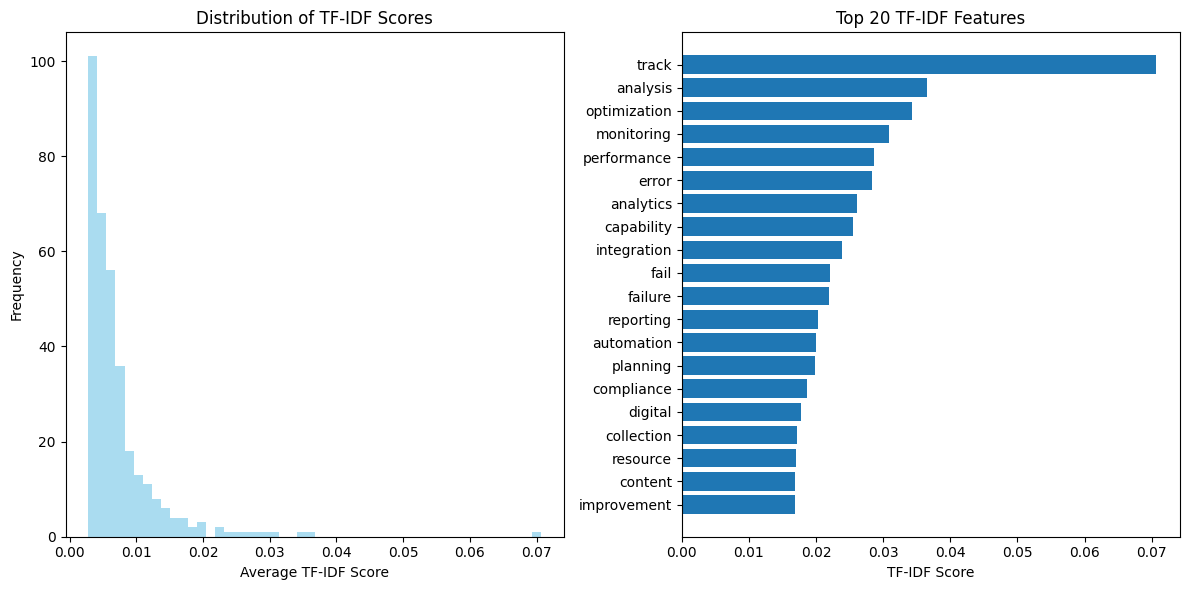

In [18]:
# Visualize TF-IDF feature distribution
feature_names = tfidf_extractor.get_feature_names()
avg_scores = np.array(tfidf_features.mean(axis=0)).flatten()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(avg_scores, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Frequency')
plt.title('Distribution of TF-IDF Scores')

plt.subplot(1, 2, 2)
top_20_features, top_20_scores = zip(*top_features[:20])
plt.barh(range(len(top_20_features)), top_20_scores)
plt.yticks(range(len(top_20_features)), top_20_features)
plt.xlabel('TF-IDF Score')
plt.title('Top 20 TF-IDF Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Feature Extraction Using Word2Vec

In [19]:
class Word2VecExtractor:
    def __init__(self, vector_size=100, window=5, min_count=2, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, texts):    # Train Word2Vec model
        # Prepare sentences
        sentences = [text.split() for text in texts if text.strip()]

        # Train Word2Vec model
        self.model = Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers,
            sg=1,  # Skip-gram model
            epochs=10
        )

        print(f"Word2Vec model trained with {len(self.model.wv)} words")
        return self

    def transform(self, texts):        # Transform texts to Word2Vec features
        if self.model is None:
            raise ValueError("Model not fitted. Call fit() first.")

        features = []
        for text in texts:
            words = text.split()
            word_vectors = [self.model.wv[word] for word in words if word in self.model.wv]

            if word_vectors:
                # Average word vectors to create document vector
                doc_vector = np.mean(word_vectors, axis=0)
            else:
                # If no words in vocabulary, use zero vector
                doc_vector = np.zeros(self.vector_size)

            features.append(doc_vector)

        return np.array(features)

    def fit_transform(self, texts):         # Fit model and transform texts
        return self.fit(texts).transform(texts)

    def get_similar_words(self, word, n=10):  # Get most similar words
        if self.model is None or word not in self.model.wv:
            return []
        return self.model.wv.most_similar(word, topn=n)

    def get_vocabulary_stats(self):          # Get vocabulary statistics
        if self.model is None:
            return {}

        vocab = self.model.wv.key_to_index
        word_counts = Counter(vocab.keys())

        return {
            'vocabulary_size': len(vocab),
            'most_common_words': word_counts.most_common(10),
            'vector_size': self.vector_size
        }

In [20]:
# Initialize and fit Word2Vec
w2v_extractor = Word2VecExtractor(vector_size=100, window=5, min_count=2)
w2v_features = w2v_extractor.fit_transform(text_data)

print(f"Word2Vec Features Shape: {w2v_features.shape}")

Word2Vec model trained with 267 words
Word2Vec Features Shape: (194, 100)


In [21]:
# Display vocabulary statistics
vocab_stats = w2v_extractor.get_vocabulary_stats()
print(f"Vocabulary size: {vocab_stats['vocabulary_size']}")
print(f"Vector size: {vocab_stats['vector_size']}")

Vocabulary size: 267
Vector size: 100


In [22]:
# Show similar words for common terms
common_words = ['error', 'user', 'system', 'database', 'authentication']
print(f"\nSimilar words analysis:")
for word in common_words:
    similar_words = w2v_extractor.get_similar_words(word, 5)
    if similar_words:
        print(f"{word}: {[w[0] for w in similar_words[:3]]}")


Similar words analysis:
error: ['track', 'identification', 'analysis']
authentication: ['detection', 'distribution', 'content']



Visualizing Word2Vec embeddings with t-SNE...


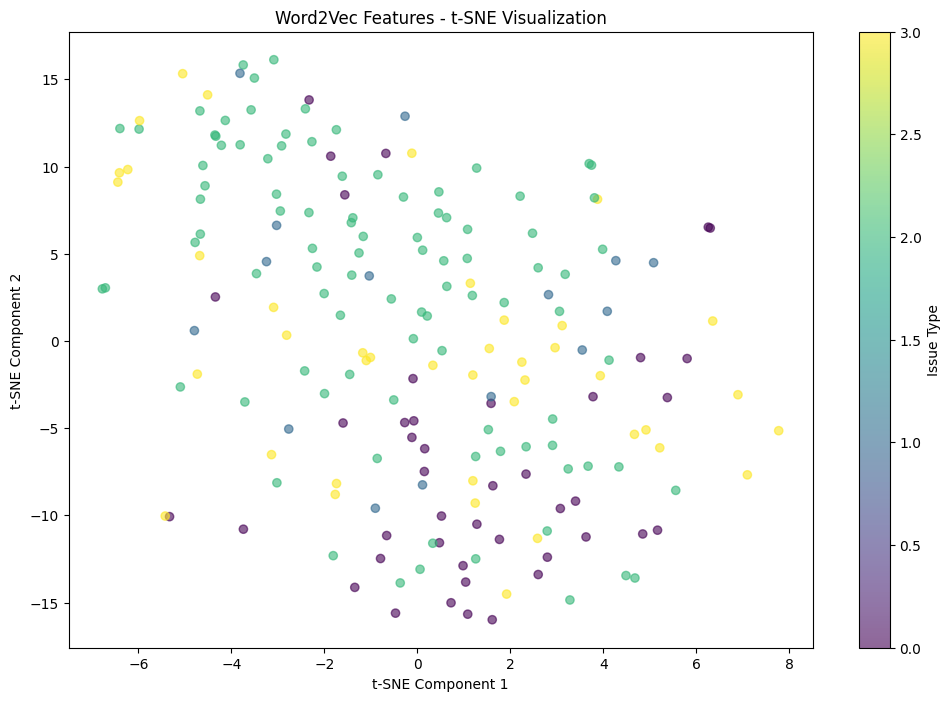

In [23]:
# Visualize Word2Vec embeddings using t-SNE
print("\nVisualizing Word2Vec embeddings with t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
w2v_tsne = tsne.fit_transform(w2v_features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(w2v_tsne[:, 0], w2v_tsne[:, 1],
                     c=pd.Categorical(df['Issue Type']).codes,
                     cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Issue Type')
plt.title('Word2Vec Features - t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Feature Extraction Using BERT - BERT Embeddings

In [24]:
class BERTExtractor:
    def __init__(self, model_name='bert-base-uncased', max_length=128):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()  # Set to evaluation mode

    def extract_features(self, texts, batch_size=8):
        """Extract BERT features from texts"""
        features = []

        # Process texts in batches
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            encoded = self.tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=self.max_length,
                return_tensors='pt'
            )

            # Get BERT embeddings
            with torch.no_grad():
                outputs = self.model(**encoded)
                # Use [CLS] token embeddings (first token)
                cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
                features.extend(cls_embeddings)

        return np.array(features)


In [25]:
# Initialize BERT extractor
bert_extractor = BERTExtractor(model_name='bert-base-uncased', max_length=128)

In [26]:
# Extract BERT features (using smaller batch size for memory efficiency)
print("Extracting BERT features... This may take a few minutes.")
bert_features = bert_extractor.extract_features(text_data.tolist(), batch_size=4)

Extracting BERT features... This may take a few minutes.


In [27]:
print(f"BERT Features Shape: {bert_features.shape}")
print(f"Feature vector size: {bert_features.shape[1]}")

BERT Features Shape: (194, 768)
Feature vector size: 768



Visualizing BERT embeddings with PCA...


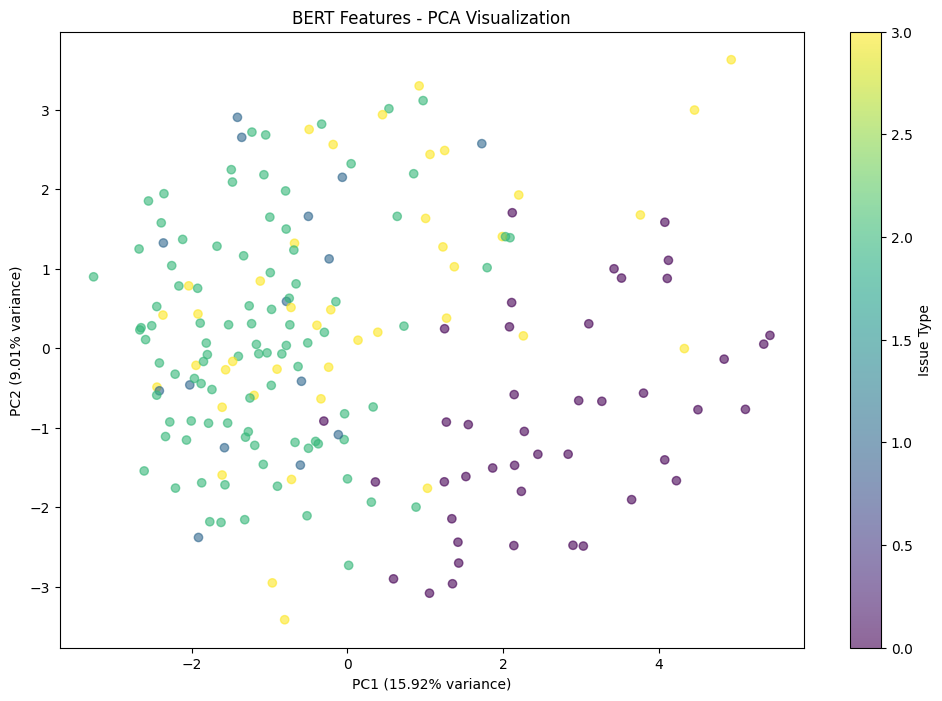

In [28]:
# Visualize BERT embeddings using PCA
print("\nVisualizing BERT embeddings with PCA...")
pca = PCA(n_components=2)
bert_pca = pca.fit_transform(bert_features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(bert_pca[:, 0], bert_pca[:, 1],
                     c=pd.Categorical(df['Issue Type']).codes,
                     cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Issue Type')
plt.title('BERT Features - PCA Visualization')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

# Feature Extraction Using Sentence Transformers

In [29]:
class SentenceTransformerExtractor:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)

    def extract_features(self, texts):
        # Extract sentence embeddings
        embeddings = self.model.encode(texts, show_progress_bar=True)
        return embeddings

In [30]:
# Initialize Sentence Transformer
st_extractor = SentenceTransformerExtractor('all-MiniLM-L6-v2')

In [31]:
# Extract features
print("Extracting Sentence Transformer features...")
st_features = st_extractor.extract_features(text_data.tolist())

print(f"Sentence Transformer Features Shape: {st_features.shape}")
print(f"Feature vector size: {st_features.shape[1]}")

Extracting Sentence Transformer features...


Batches: 100%|██████████| 7/7 [00:00<00:00, 11.01it/s]

Sentence Transformer Features Shape: (194, 384)
Feature vector size: 384


# Feature Comparison and Analysis

In [32]:
# Creating a comparison dataframe
feature_comparison = pd.DataFrame({
    'Method': ['TF-IDF', 'Word2Vec', 'BERT', 'Sentence Transformer'],
    'Features': [tfidf_features.shape[1], w2v_features.shape[1], bert_features.shape[1], st_features.shape[1]],

    'Sparsity': [
        (tfidf_features == 0).sum()/ tfidf_features.size,
        (w2v_features == 0).sum() / w2v_features.size,
        (bert_features == 0).sum() / bert_features.size,
        (st_features == 0).sum() / st_features.size
    ]
})

In [33]:
print("Feature Extraction Methods Comparison:")
print(feature_comparison)

Feature Extraction Methods Comparison:
                 Method  Features   Sparsity
0                TF-IDF       341  47.750184
1              Word2Vec       100   0.000000
2                  BERT       768   0.000000
3  Sentence Transformer       384   0.000000


##Here's what each column in the DataFrame represents:

* Method: The name of the feature extraction technique.

* Features: The number of features (dimensions) generated by each method. You can see that BERT resulted in the highest number of features (768), while Word2Vec has the fewest (100).

* Sparsity: This metric indicates how many of the values in the feature matrix are zero.

* TF-IDF has a sparsity of approximately 47.75%, meaning almost half of its features are zero. This is typical for TF-IDF as it creates a large vocabulary where many words don't appear in every document.

* Word2Vec, BERT, and Sentence Transformer all have a sparsity of 0.0%, indicating that none of their feature values are exactly zero. This is because these methods produce dense vector representations where every dimension usually has a non-zero value.

This DataFrame provides a concise summary of the output dimensions and the density of the feature representations for each method.

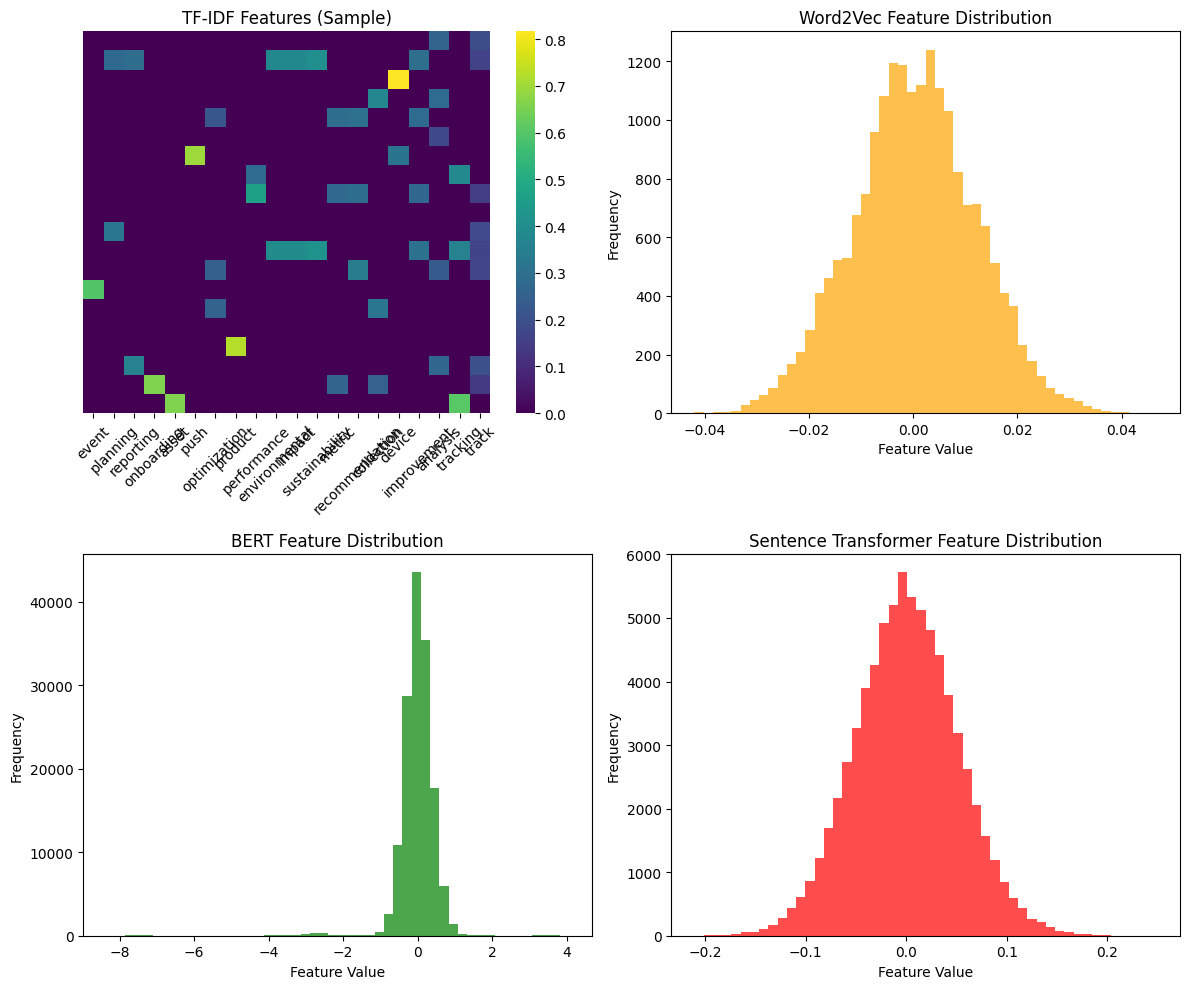

In [36]:
# Visualize feature dimensions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# TF-IDF heatmap (sample)
sample_indices = np.random.choice(len(text_data), 20, replace=False)
sample_features = tfidf_features[sample_indices].toarray()
top_feature_indices = np.argsort(np.mean(sample_features, axis=0))[-20:]
sns.heatmap(sample_features[:, top_feature_indices],
            xticklabels=tfidf_extractor.get_feature_names()[top_feature_indices].tolist(),
            yticklabels=False, ax=axes[0,0], cmap='viridis')
axes[0,0].set_title('TF-IDF Features (Sample)')
axes[0,0].tick_params(axis='x', rotation=45)

# Word2Vec feature distribution
axes[0,1].hist(w2v_features.flatten(), bins=50, alpha=0.7, color='orange')
axes[0,1].set_title('Word2Vec Feature Distribution')
axes[0,1].set_xlabel('Feature Value')
axes[0,1].set_ylabel('Frequency')

# BERT feature distribution
axes[1,0].hist(bert_features.flatten(), bins=50, alpha=0.7, color='green')
axes[1,0].set_title('BERT Feature Distribution')
axes[1,0].set_xlabel('Feature Value')
axes[1,0].set_ylabel('Frequency')

# Sentence Transformer feature distribution
axes[1,1].hist(st_features.flatten(), bins=50, alpha=0.7, color='red')
axes[1,1].set_title('Sentence Transformer Feature Distribution')
axes[1,1].set_xlabel('Feature Value')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [39]:
# Save features as numpy arrays
np.save('tfidf_features.npy', tfidf_features.toarray())
np.save('w2v_features.npy', w2v_features)
np.save('bert_features.npy', bert_features)
np.save('st_features.npy', st_features)

print("Features saved successfully!")
print("Files created:")
print("- tfidf_features.npy")
print("- w2v_features.npy")
print("- bert_features.npy")
print("- st_features.npy")

Features saved successfully!
Files created:
- tfidf_features.npy
- w2v_features.npy
- bert_features.npy
- st_features.npy


In [40]:
def load_features():
    """Load saved features"""
    return {
        'tfidf': np.load('tfidf_features.npy'),
        'w2v': np.load('w2v_features.npy'),
        'bert': np.load('bert_features.npy'),
        'st': np.load('st_features.npy')
    }

def extract_features_for_new_text(text, method='all'):
    """Extract features for new text"""
    results = {}

    if method in ['all', 'tfidf']:
        results['tfidf'] = tfidf_extractor.transform([text]).toarray()

    if method in ['all', 'w2v']:
        results['w2v'] = w2v_extractor.transform([text])

    if method in ['all', 'bert']:
        results['bert'] = bert_extractor.extract_features([text])

    if method in ['all', 'st']:
        results['st'] = st_extractor.extract_features([text])

    return results

In [49]:
# Example usage
example_text = "user authentication failure check what is causing login issues and fix it in the next 24 hours"
print(f"\nExample feature extraction for: '{example_text}'")

new_features = extract_features_for_new_text(example_text, method='all')
for method, features in new_features.items():
    print(f"{method.upper()}: {features.shape}")


Example feature extraction for: 'user authentication failure check what is causing login issues and fix it in the next 24 hours'


Batches: 100%|██████████| 1/1 [00:00<00:00, 87.58it/s]

TFIDF: (1, 341)
W2V: (1, 100)
BERT: (1, 768)
ST: (1, 384)
